## Introduction 

The aim of this notebook is to demonstrate how to use Hugging Face's TRL (Transformers Reinforcement Learning) library to finetune a 4bit GPTQ quantized model. More details on how to quantize a model using GPTQ can be found in my medium article [here](https://medium.com/@arunsreekuttan1996/quantizing-qwen2-vl-models-with-gptqmodel-a-complete-guide-for-multi-modal-model-compression-and-f329ea18a17b)

If you are okay with using a 4bit nf4 (bitsandbytes) quantized model, you can use either Unsloth's fine-tuning notebooks or this notebook with changing the quantization configurations, which will be explained later.

## Prepare Dataset

We'll be using the `unsloth/LaTeX_OCR` dataset from Hugging Face. The goal is to convert these images into a computer readable form - ie in LaTeX form, so we can render it or to use in LaTeX documents. 80% of the dataset is used for training and 20% for testing.

You can access the dataset [here](https://www.google.com/url?q=https%3A%2F%2Fhuggingface.co%2Fdatasets%2Funsloth%2FLaTeX_OCR)

In [1]:
from datasets import load_dataset
dataset,test_dataset = load_dataset("unsloth/LaTeX_OCR", split=['train[:80%]', 'test[:20%]'])

/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let’s take a look at the structure of the dataset. We shall see what the 2nd image is, and what caption it had.

In [2]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 54949
})

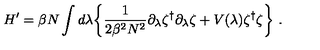

In [3]:
# Display a sample image from the dataset
dataset[2]["image"]

In [4]:
# Render a sample LaTeX text from the dataset
from IPython.display import display, Math, Latex
latex = dataset[2]["text"]
print(latex)
display(Math(latex))

H ^ { \prime } = \beta N \int d \lambda \biggl \{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \biggr \} \ .


<IPython.core.display.Math object>

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [5]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
   return [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]

Now, let’s format the data using the chatbot format for finetuning:

In [6]:
# Training dataset
converted_dataset = [convert_to_conversation(sample) for sample in dataset]
# Test dataset
converted_test_dataset = [convert_to_conversation(sample) for sample in test_dataset]

We look at how the conversations are structured for the second example:

In [7]:
converted_dataset[2][0]

{'role': 'user',
 'content': [{'type': 'text',
   'text': 'Write the LaTeX representation for this image.'},
  {'type': 'image',
   'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=320x50>}]}

## Inference using Quantized Model

Let's load the quantized model and run inference on the second image from the dataset before we finetune it. We’ll be using 4 bit GPTQ-Quantized version of Qwen/Qwen2-VL-2B-Instruct. More details on how to quantize a model using GPTQ can be found in my medium article [here](https://medium.com/@arunsreekuttan1996/quantizing-qwen2-vl-models-with-gptqmodel-a-complete-guide-for-multi-modal-model-compression-and-f329ea18a17b)

In [8]:
# Import Libraries
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, GPTQConfig
from qwen_vl_utils import process_vision_info
import torch

# Configure GPTQ settings
gptq_config = GPTQConfig(bits=4, use_exllama=False)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "arunmadhusudh/Qwen2-VL-2B-Instruct-4bit-GPTQ_T4_tr4512",
    torch_dtype=torch.float16,
    device_map="auto",
    quantization_config=gptq_config
)
# Set up processor with optimal token ranges
min_pixels = 28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained(
    "arunmadhusudh/Qwen2-VL-2B-Instruct-4bit-GPTQ_T4_tr4512",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/transformers/quantizers/auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.However, loading attributes (e.g. ['backend', 'use_cuda_fp16', 'use_exllama', 'max_input_length', 'exllama_config']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.
  warnings.warn(warning_msg)


INFO  ENV: Auto setting PYTORCH_CUDA_ALLOC_CONF='expandable_segments:True' for memory saving.
INFO  ENV: Auto setting CUDA_DEVICE_ORDER=PCI_BUS_ID for correctness.          
INFO   Kernel: Auto-selection: adding candidate `TritonV2QuantLinear`          


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


INFO  Format: Converting `checkpoint_format` from `gptq` to internal `gptq_v2`.
INFO  Format: Converting GPTQ v1 to v2                                         
INFO  Format: Conversion complete: 0.01124262809753418s                        
INFO  Optimize: `TritonV2QuantLinear` compilation triggered.                   


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


if you are okay with using a 4bit nf4 (bitsandbytes) quantized model, you can use either Unsloth's fine-tuning notebooks or this notebook with changing the quantization configurations below.

```python

# Import Libraries
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
import torch

# Configure quantization settings 
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.float16
)

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",
    quantization_config=nf4_config,
    device_map="auto",
)
# Set up processor with optimal token ranges
min_pixels = 28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)
```

In [12]:
# Prepare the input for the model
instruction = "Write the LaTeX representation for this image."
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text =  processor.apply_chat_template(messages, add_generation_prompt = True)

# Convert the image to the required format
image_inputs, _ = process_vision_info(converted_dataset[2])

inputs = processor(
    text=[input_text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text)

["\\[\nH' = \\beta N \\int d\\lambda \\left\\{ \\frac{1}{2\\beta^2 N^2} \\partial_\\lambda \\zeta^\\dagger \\partial_\\lambda \\zeta + V(\\lambda) \\zeta^\\dagger \\right\\} .\n\\]"]


## Train the Model

We will use Huggingface TRL library to finetune our already 4-bit quantized model using GPTQ. 

Let's configure the parameters for LoRA adapter first and check the number of trainable parameters. Note that we are only training the LoRA adapter for language model, and not the vision encoder. This is because, for our purpose the already trained vision encoder is sufficient to extract the features from the images, and we are only finetuning the language model to generate the LaTeX code. Also, my aim is to serve the model using vLLM , which does not support LoRA adapters on vision encoders yet. 

In [ ]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules=["down_proj", "o_proj", "k_proj", "q_proj", "gate_proj", "up_proj", "v_proj"], 
    init_lora_weights="gaussian",
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/peft/tuners/lora/layer.py:112: UserWarning: Unsupported layer type '<class 'gptqmodel.nn_modules.qlinear.tritonv2.TritonV2QuantLinear'>' encountered, proceed at your own risk.
  warnings.warn(


trainable params: 18,464,768 || all params: 917,197,312 || trainable%: 2.0132


we’ll define the training arguments using the SFTConfig class from the TRL library. 

In [ ]:
from trl import SFTConfig

# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir="GPTQ_LoRA", # Directory to save the model
    per_device_train_batch_size = 8, # Batch size for training
    gradient_accumulation_steps = 1, # Steps to accumulate gradients
    per_device_eval_batch_size = 4, # Batch size for evaluation
    warmup_steps = 5,
    num_train_epochs = 3, # Number of training epochs
    # Optimizer and scheduler settings
    learning_rate = 2e-4, # Learning rate for training
    optim = "adamw_torch_fused", # Optimizer type
    weight_decay = 0.01, # Weight decay for regularization
    lr_scheduler_type = "linear", # Type of learning rate scheduler
    # Mixed precision and gradient settings
    fp16 = False,
    bf16 = True,
    # Logging and evaluation
    logging_steps = 1,
    seed = 3407,
    report_to = "none",     # For Weights and Biases
    save_strategy="epoch",  # We will save the model at the end of each epoch
    eval_strategy="epoch",  # Evaluate the model at the end of each epoch

    # You MUST put the below items for vision finetuning:
    remove_unused_columns = False,
    dataset_text_field = "",
    dataset_kwargs = {"skip_prepare_dataset": True},
    dataset_num_proc = 4,
    max_seq_length = 2048,
    label_names = ["labels"]
)

We need a collator function to properly retrieve and batch the data during the training procedure. This function will handle the formatting of our dataset inputs, ensuring they are correctly structured for the model. Let’s define the collator function below.

In [9]:
from transformers import Qwen2VLProcessor

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]  # Prepare texts for processing
    image_inputs = [process_vision_info(example)[0] for example in examples]  # Process the images to extract inputs

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)  # Encode texts and images into tensors

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):  # Check if the processor is Qwen2VLProcessor
        image_tokens = [151652, 151653, 151655]  # Specific image token IDs for Qwen2VLProcessor
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]  # Convert image token to ID

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels  # Add labels to the batch

    return batch  # Return the prepared batch

Now, we will define the SFTTrainer, which is a wrapper around the transformers.Trainer class and inherits its attributes and methods. This class simplifies the fine-tuning process by properly initializing the PeftModel when a PeftConfig object is provided

In [10]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    processing_class=processor.tokenizer,
    args=training_args,
    train_dataset=converted_dataset,
    eval_dataset=converted_test_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,

)

/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Let's train the model. It approximately took 2 hours to train on a single A100 GPU for 3 epochs. 

In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.065800,0.097750
2,0.035600,0.088671
3,0.017100,0.097618


TrainOutput(global_step=20607, training_loss=0.07141266917244371, metrics={'train_runtime': 6808.4222, 'train_samples_per_second': 24.212, 'train_steps_per_second': 3.027, 'total_flos': 1.2934115043647078e+17, 'train_loss': 0.07141266917244371})

## Test Finetuned model

Restart the kernel and run the inference on the finetuned model. 

First, we will load the baseline model following the same pipeline as before

In [10]:
# Import Libraries
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, GPTQConfig
from qwen_vl_utils import process_vision_info
import torch

# Configure GPTQ settings - crucial for T4 GPUs
gptq_config = GPTQConfig(bits=4, use_exllama=False)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "arunmadhusudh/Qwen2-VL-2B-Instruct-4bit-GPTQ_T4_tr4512",
    torch_dtype=torch.float16,
    device_map="auto",
    quantization_config=gptq_config
)
# Set up processor with optimal token ranges
min_pixels = 28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained(
    "arunmadhusudh/Qwen2-VL-2B-Instruct-4bit-GPTQ_T4_tr4512",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

INFO   Kernel: Auto-selection: adding candidate `TritonV2QuantLinear`          


/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/transformers/quantizers/auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.However, loading attributes (e.g. ['backend', 'use_cuda_fp16', 'use_exllama', 'max_input_length', 'exllama_config']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.
  warnings.warn(warning_msg)
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


INFO  Format: Converting `checkpoint_format` from `gptq` to internal `gptq_v2`.
INFO  Format: Conversion complete: 0.006639242172241211s                       


We will use a sample from the test set to evaluate our model. 

In [13]:
from IPython.display import display, Math, Latex

index = 25
latex = test_dataset[index]["text"]
latex

'( 5 . 1 7 ) = - \\frac { ( - i ) ^ { m + n - 1 } } { ( m + n - 1 ) ! } z ^ { m + n - 1 } \\left\\{ \\frac { 1 } { 4 } \\frac { 1 } { \\lambda } z ^ { 2 \\lambda } + \\frac { 1 } { 2 } \\ln ( z ) \\right\\}'

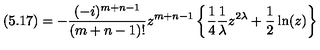

In [22]:
test_dataset[index]["image"]

let's render the ground truth equation

In [14]:
display(Math(latex))

<IPython.core.display.Math object>

In [15]:
instruction = "Write just the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

input_text =  processor.apply_chat_template(messages, add_generation_prompt = True)
image_inputs, _ = process_vision_info(converted_test_dataset[index])
inputs = processor(
    text=[input_text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

Let's load the LoRA adapters

In [16]:
adapter_path_epoch_1 = "/home/madhusudhanan.a/vlms/GPTQ_LoRA/checkpoint-6869"
adapter_path_epoch_2 = "/home/madhusudhanan.a/vlms/GPTQ_LoRA/checkpoint-13738"
adapter_path_epoch_3 = "/home/madhusudhanan.a/vlms/GPTQ_LoRA/checkpoint-20607"
model.load_adapter(adapter_path_epoch_1,adapter_name="epoch_1")
model.load_adapter(adapter_path_epoch_2,adapter_name="epoch_2")
model.load_adapter(adapter_path_epoch_3,adapter_name="epoch_3")

/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/peft/tuners/lora/layer.py:112: UserWarning: Unsupported layer type '<class 'gptqmodel.nn_modules.qlinear.tritonv2.TritonV2QuantLinear'>' encountered, proceed at your own risk.
  warnings.warn(
/home/madhusudhanan.a/.conda/envs/tensorrt_env/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Let's run the inference using baseline quantized model. We will use `model.disable_adapters_adapters()` to disable lora adapters. Make sure to enable adapters back using `model.enable_adapters()`

In [17]:
model.disable_adapters() # Disable adapters
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text)

model.enable_adapters() # Enable adapters back

['\\begin{equation}\n\\frac{1}{m+n-1}z^{m+n-1} = \\frac{1}{4\\lambda}z^{2\\lambda} + \\frac{1}{\\ln(z)}\n\\end{equation}']


let's render the output from baseline quantized model

In [18]:
display(Math(output_text[0]))

<IPython.core.display.Math object>

As you can see, the baseline quantized model does not perform well in predicting the correct latex equation.

Now let's set the LoRA adapter from epoch 3 as the active adapter and run inference

In [19]:
model.set_adapter("epoch_3")  # Set the adapter to the last epoch

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text)

display(Math(output_text[0]))

['( 5 . 1 7 ) = - \\frac { ( - i ) ^ { m + n - 1 } } { ( m + n - 1 ) ! } z ^ { m + n - 1 } \\{ \\frac { 1 } { 4 } \\frac { 1 } { \\lambda } z ^ { 2 \\lambda } + \\frac { 1 } { 2 } \\ln ( z ) \\}']


<IPython.core.display.Math object>

The fine-tuned model performs well on the test sample !!

## Evaluate the model

Let's evaluate the model on test dataset to see how well our model performs on the test set. We will evaluate our model using the following Metric:
1. [Bleu](https://huggingface.co/spaces/evaluate-metric/bleu)
2. [Levenshtein edit distance](https://medium.com/@ethannam/understanding-the-levenshtein-distance-equation-for-beginners-c4285a5604f0)

In [20]:
# Remove unnecessary whitespace from LaTeX code.
import re
def post_process(s: str):
    text_reg = r'(\\(operatorname|mathrm|text|mathbf)\s?\*? {.*?})'
    letter = '[a-zA-Z]'
    noletter = '[\W_^\d]'
    names = [x[0].replace(' ', '') for x in re.findall(text_reg, s)]
    s = re.sub(text_reg, lambda match: str(names.pop(0)), s)
    news = s
    while True:
        s = news
        news = re.sub(r'(?!\\ )(%s)\s+?(%s)' % (noletter, noletter), r'\1\2', s)
        news = re.sub(r'(?!\\ )(%s)\s+?(%s)' % (noletter, letter), r'\1\2', news)
        news = re.sub(r'(%s)\s+?(%s)' % (letter, noletter), r'\1\2', news)
        if news == s:
            break
    return s

In [55]:
# To evaluate Baseline model, disable adapter first (Uncomment the line below)
# model.disable_adapters()

In [21]:
import evaluate
import Levenshtein
from tqdm import tqdm
import torch
from torch.nn import functional as F


# Initialize evaluation tools
bleu_metric = evaluate.load("bleu")

all_predictions = []
all_references = []
norm_edit_dists = []

instruction = "Write the LaTeX representation for this image."
batch_size = 64
n_samples = len(converted_test_dataset)

for start_idx in tqdm(range(0, n_samples, batch_size), desc="Evaluating"):
    batch = converted_test_dataset[start_idx : start_idx + batch_size]

    batch_texts = []
    batch_images = []
    batch_ground_truths = []

    for sample in batch:
        messages = [
            {"role": "user", "content": [
                {"type": "image"},
                {"type": "text", "text": instruction}
            ]}
        ]
        input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
        batch_texts.append(input_text)

        image_inputs, _ = process_vision_info(sample)
        batch_images.append(image_inputs)

        gt = sample[1]['content'][0]['text']
        batch_ground_truths.append(gt)

    # Process batch
    inputs = processor(
        text=batch_texts,
        images=batch_images,
        padding=True,
        return_tensors="pt"
    ).to("cuda")

    # Inference
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=128)

    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    batch_outputs = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    for pred, true in zip(batch_outputs, batch_ground_truths):
        all_predictions.append(pred)
        all_references.append([true])  # wrap for BLEU

        norm_dist = Levenshtein.distance(post_process(pred), post_process(true)) / max(len(pred), len(true))
        norm_edit_dists.append(norm_dist)
    
# Final evaluation
bleu_result = bleu_metric.compute(predictions=all_predictions, references=all_references)
average_edit_distance = sum(norm_edit_dists) / len(norm_edit_dists)


# Print results
print("BLEU Score:", bleu_result['bleu'])
print("Average Normalized Edit Distance:", average_edit_distance)


Evaluating: 100%|██████████| 24/24 [03:43<00:00,  9.32s/it]


BLEU Score: 0.832773655559199
Average Normalized Edit Distance: 0.0922510220772206


## Push to Hub

Finally, we can push the model to the Hugging Face Hub. This will allow others to use our finetuned model easily.

In [ ]:
model.push_to_hub("arunmadhusudh/qwen2_VL_2B_LatexOCR_qlora_qptq_epoch3", token = "ur_token_here") # Online saving

adapter_model.safetensors: 100%|██████████| 73.9M/73.9M [00:01<00:00, 50.9MB/s]


CommitInfo(commit_url='https://huggingface.co/arunmadhusudh/qwen2_VL_2B_LatexOCR_qlora_qptq_epoch1/commit/976b7bec87b7cb988436bbbf7b4870354254eb13', commit_message='Upload Qwen2VLForConditionalGeneration', commit_description='', oid='976b7bec87b7cb988436bbbf7b4870354254eb13', pr_url=None, repo_url=RepoUrl('https://huggingface.co/arunmadhusudh/qwen2_VL_2B_LatexOCR_qlora_qptq_epoch1', endpoint='https://huggingface.co', repo_type='model', repo_id='arunmadhusudh/qwen2_VL_2B_LatexOCR_qlora_qptq_epoch1'), pr_revision=None, pr_num=None)